### advent callendar


# Get metadata

# 0. ライブラリのインポートと設定

In [1]:
from time import sleep
from tqdm import tqdm
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path

# このパスの下にダウンロードしたデータやらいろいろ置きます。
DATA_PATH = Path("../data")
(DATA_PATH / "raw/xbrl_doc").mkdir(parents=True, exist_ok=True) # ダウンロードしたzipファイルの保管場所
(DATA_PATH / "raw/xbrl_doc_ext").mkdir(parents=True, exist_ok=True) # zipファイルから抽出したXBRL、スキーマファイル、リンクベースファイルの保管場所

# EDINET APIのAPIキーを入力してください。
your_api_key: str = input("EDINET API keyを入力してください: ")


# 1. 提出書類一覧の取得

In [2]:
from edinet_xbrl_prep.edinet_api import request_term, edinet_response_metadata, request_doc, EdinetResponseDf, EdinetResponseList

In [3]:
res_results:EdinetResponseList = request_term(api_key=your_api_key, start_date_str='2024-06-15', end_date_str='2024-06-30')

100%|██████████| 16/16 [01:13<00:00,  4.61s/it]


In [4]:
edinet_response_metadata_obj = edinet_response_metadata(
    tse_sector_url = "https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls",
    tmp_path_str = str(DATA_PATH)
)
edinet_response_metadata_obj.set_data(res_results)
filename = str(DATA_PATH / "data.jsonl")
edinet_response_metadata_obj.save(filename)

In [5]:
edinet_response_metadata_obj = edinet_response_metadata(
    filename = str(DATA_PATH / "data.jsonl"),
    tse_sector_url = "https://www.jpx.co.jp/markets/statistics-equities/misc/tvdivq0000001vg2-att/data_j.xls",
    tmp_path_str = str(DATA_PATH)
    )

yuho_df:EdinetResponseDf = edinet_response_metadata_obj.get_yuho_df()

In [6]:
yuho_df_filtered:EdinetResponseDf = yuho_df.query("sector_label_33 == '食料品'")
print("業種が食料品の有価証券報告書数:",len(yuho_df_filtered))

業種が食料品の有価証券報告書数: 79


In [7]:
yuho_df_filtered = yuho_df_filtered.set_index("docID").head(30)
yuho_df_filtered.columns

Index(['index', 'access_date', 'seqNumber', 'edinetCode', 'secCode', 'JCN',
       'filerName', 'fundCode', 'ordinanceCode', 'formCode', 'docTypeCode',
       'periodStart', 'periodEnd', 'submitDateTime', 'docDescription',
       'issuerEdinetCode', 'subjectEdinetCode', 'subsidiaryEdinetCode',
       'currentReportReason', 'parentDocID', 'opeDateTime', 'withdrawalStatus',
       'docInfoEditStatus', 'disclosureStatus', 'xbrlFlag', 'pdfFlag',
       'attachDocFlag', 'englishDocFlag', 'csvFlag', 'legalStatus',
       'sector_label_33'],
      dtype='object')

In [8]:
yuho_df_filtered.head()

,index,access_date,seqNumber,edinetCode,secCode,JCN,filerName,fundCode,ordinanceCode,formCode,...,withdrawalStatus,docInfoEditStatus,disclosureStatus,xbrlFlag,pdfFlag,attachDocFlag,englishDocFlag,csvFlag,legalStatus,sector_label_33
docID,,,,,,,,,,,,,,,,,,,,,
S100TMYO,231,2024-12-18,232,E00385,22200,4110001006378,亀田製菓株式会社,,010,030000,...,0,0,0,1,1,1,0,1,1,食料品
S100TNWB,198,2024-12-18,199,E31012,28830,2010001048993,株式会社大冷,,010,030000,...,0,0,0,1,1,1,0,1,1,食料品
S100TLP1,214,2024-12-18,215,E00406,22670,7010401029746,株式会社ヤクルト本社,,010,030000,...,0,0,0,1,1,1,0,1,1,食料品
S100TN7J,514,2024-12-18,515,E00354,21070,2010001034845,東洋精糖株式会社,,010,030000,...,0,0,0,1,1,1,0,1,1,食料品
S100TO96,580,2024-12-18,581,E27294,25880,9090001010626,株式会社プレミアムウォーターホールディングス,,010,030000,...,0,0,0,1,1,1,0,1,1,食料品


# 2. 有価証券報告書のダウンロード

In [9]:
res_results = []
for docid in tqdm(yuho_df_filtered.index):
    out_filename = str(DATA_PATH / "raw/xbrl_doc" / (docid + ".zip"))
    res_results.append(request_doc(api_key=your_api_key, docid=docid, out_filename_str=out_filename))
    sleep(0.5)
print("取得失敗数: ",len([res for res in res_results if res.status == 'failure']))

100%|██████████| 30/30 [01:17<00:00,  2.57s/it]

取得失敗数:  0


# 3. Preprocessing

In [10]:
from edinet_xbrl_prep.link_base_file_analyzer import account_list_common
from edinet_xbrl_prep.fs_tbl import get_fs_tbl, FsDataDf


In [11]:
# 3.1 共通タクソノミの取得（100秒程度）
account_list_common_obj_2024 = account_list_common(
    data_path=DATA_PATH,
    account_list_year="2024"
)

In [12]:
# arelleの設定（特段不要ですが、）
arelle_temp_dir = Path(DATA_PATH/"tmp")
arelle_dir = arelle_temp_dir.joinpath('arelle_tmp')
arelle_dir.mkdir(exist_ok=True)
cmd_arelle_dir = '--xdgConfigHome=' + str(arelle_dir)
sys.argv.append(cmd_arelle_dir)


#### 財務数値の取り出し
有価証券報告書XBRLから財務数値を取得します。

In [13]:
# リンクロール検索キーワード
fs_dict = {
    'BS':["_BalanceSheet","_ConsolidatedBalanceSheet"],
    'PL':["_StatementOfIncome","_ConsolidatedStatementOfIncome"],
    'CF':["_StatementOfCashFlows","_ConsolidatedStatementOfCashFlows"],
    'SS':["_StatementOfChangesInEquity","_ConsolidatedStatementOfChangesInEquity"],
    'notes':["_Notes","_ConsolidatedNotes"],
    'report':["_CabinetOfficeOrdinanceOnDisclosure"]}

In [14]:
import pandera as pa
from pandera.typing import DataFrame, Series

class FsBigTableDf(FsDataDf):
    """
    'key': （スキーマ:要素名）like 'jpcrp_cor:NetSales'. 勘定科目コードと思って良い
    'data_str': data (string) like '1000000'
    'decimals': 表示単位 -3:（千円）, -6:（百万円）, -9:Billions（十億円）。有効数字の役割
    'context_ref': コンテキスト情報（連結or個別、会計期間、エンティティなどを区別。かなり自由に利用される。）
    'element_name': 要素名
    'unit': JPY or USD
    'period_type': duration（フロー） or instant（ストック）
    'isTextBlock_flg':1:テキストブロック 0:それ以外
    'abstract_flg': 1:アブストラクト情報（ヘッダーのみ） 0:それ以外
    'period_start': period_type == durationの場合 当期末日, period_type == instantの場合 None
    'period_end': period_type == durationの場合 当期末日, period_type == instantの場合 当期末日
    'instant_date': period_type == durationの場合 None, period_type == instantの場合 当期末日
    'end_date_pv': period_type == durationの場合 前期末日, period_type == instantの場合 None
    'instant_date_pv': period_type == durationの場合 None, period_type == instantの場合 前期対象日
    'scenario': シナリオ（セグメント情報の抽出時に使用する）
    'role': BSやPLなどの目次項目を表す。拡張リンクロールのroleURI
    'label_jp': 日本語ラベル
    'order': 表示順序 10^-2ごとに階層構造を持つ
    'docid': docid
    'filerName': 提出者名
    'sector_label_33': 業種
    """
    filerName: Series[str] = pa.Field(nullable=True)
    sector_label_33: Series[str] = pa.Field(nullable=True)

In [15]:
# XBRLから必要なロールの財務情報を取得
fs_tbl_df_list = []
for docid in tqdm(yuho_df_filtered.index):
    fs_tbl_df:FsDataDf = get_fs_tbl(
        account_list_common_obj=account_list_common_obj_2024,
        docid=docid,
        zip_file_str=str(DATA_PATH / "raw/xbrl_doc" / (docid + ".zip")),
        temp_path_str=str(DATA_PATH / "raw/xbrl_doc_ext" / docid),
        role_keyward_list=fs_dict['BS']+fs_dict['PL']+fs_dict['report'],
    )
    fs_tbl_df = fs_tbl_df.assign(
        filerName=yuho_df_filtered.loc[docid,'filerName'],
        sector_label_33=yuho_df_filtered.loc[docid,'sector_label_33']
    )
    fs_tbl_df_list.append(fs_tbl_df)
fs_tbl_df_all:FsBigTableDf = FsBigTableDf(pd.concat(fs_tbl_df_list))


  0%|          | 0/30 [00:00<?, ?it/s]

key in label that is not included in locator: 
{'MetricsAndTargetsClimateChangeTextBlock'}


 70%|███████   | 21/30 [09:11<04:09, 27.73s/it]

key in label that is not included in locator: 
{'StrategySupplyChainTextBlock'}


100%|██████████| 30/30 [5:37:20<00:00, 674.67s/it]   


In [16]:
fs_tbl_df_all.head()

,key,data_str,decimals,context_ref,element_name,unit,period_type,isTextBlock_flg,abstract_flg,period_start,...,scenario,role,label_jp,order,docid,non_consolidated_flg,current_flg,prior_flg,filerName,sector_label_33
130,jppfs_cor:CashAndDeposits,1462000000,-6,Prior1YearInstant_NonConsolidatedMember,CashAndDeposits,JPY,instant,0,0,None,...,"[{""ja"":[""連結個別"",""非連結又は個別""],""en"":[""Consolidated ...",rol_BalanceSheet,現金及び預金,1.020101,S100TMYO,1,0,1,亀田製菓株式会社,食料品
131,jppfs_cor:CashAndDeposits,1483000000,-6,CurrentYearInstant_NonConsolidatedMember,CashAndDeposits,JPY,instant,0,0,None,...,"[{""ja"":[""連結個別"",""非連結又は個別""],""en"":[""Consolidated ...",rol_BalanceSheet,現金及び預金,1.020101,S100TMYO,1,1,0,亀田製菓株式会社,食料品
132,jppfs_cor:AccountsReceivableTrade,8909000000,-6,Prior1YearInstant_NonConsolidatedMember,AccountsReceivableTrade,JPY,instant,0,0,None,...,"[{""ja"":[""連結個別"",""非連結又は個別""],""en"":[""Consolidated ...",rol_BalanceSheet,売掛金,1.020101,S100TMYO,1,0,1,亀田製菓株式会社,食料品
133,jppfs_cor:AccountsReceivableTrade,9186000000,-6,CurrentYearInstant_NonConsolidatedMember,AccountsReceivableTrade,JPY,instant,0,0,None,...,"[{""ja"":[""連結個別"",""非連結又は個別""],""en"":[""Consolidated ...",rol_BalanceSheet,売掛金,1.020101,S100TMYO,1,1,0,亀田製菓株式会社,食料品
134,jppfs_cor:MerchandiseAndFinishedGoods,1680000000,-6,Prior1YearInstant_NonConsolidatedMember,MerchandiseAndFinishedGoods,JPY,instant,0,0,None,...,"[{""ja"":[""連結個別"",""非連結又は個別""],""en"":[""Consolidated ...",rol_BalanceSheet,商品及び製品,1.020101,S100TMYO,1,0,1,亀田製菓株式会社,食料品


# 4. テキスト分析

In [17]:
# 有価証券報告書の前段部分を取得
text_df = fs_tbl_df_all.query("role.str.contains('CabinetOfficeOrdinanceOnDisclosure')")

## 4.1 事業上のリスクの分析

In [18]:
from janome.tokenizer import Tokenizer
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel,TfidfModel

import wordcloud as wc
import matplotlib.pyplot as plt
import matplotlib_fontja

from matplotlib_fontja import get_font_path
from matplotlib import font_manager

from edinet_xbrl_prep.text_prep import preproc_nlp

# wordcloud用に日本語のフォントを取得
font_dir_path = get_font_path()
font_dirs = [font_dir_path]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

In [19]:
business_risk_df = text_df.query("key == 'jpcrp_cor:BusinessRisksTextBlock'")

In [20]:

janome_tokenizer = Tokenizer() # janomeのトークナイザー

def tokenize_janome(text:str)->str:
    """単語分割をして、名詞と形容詞のみを取り出す"""
    return [token.surface for token in janome_tokenizer.tokenize(text) if token.part_of_speech.split(',')[0] in ['名詞','形容詞']]

business_risk_df['text_processed'] = business_risk_df.data_str.apply(preproc_nlp,drop_htmp=True,drop_number=True,reduce_return=True)
business_risk_df['text_tokenized'] = business_risk_df.text_processed.apply(tokenize_janome)

business_risk_df.head()['text_tokenized']

17    [事業, 等, リスク, 当社, リスク, マネジメント, 体制, リスク, 管理, 対応,...
19    [事業, 等, リスク, 有価, 証券, 報告, 書, 記載, 事業, 状況, 経理, 状況...
16    [事業, 等, リスク, 有価, 証券, 報告, 書, 記載, 事業, 状況, 経理, 状況...
14    [事業, 等, リスク, 有価, 証券, 報告, 書, 記載, 事業, 状況, 経理, 状況...
15    [事業, 等, リスク, 有価, 証券, 報告, 書, 記載, 事業, 状況, 経理, 状況...
Name: text_tokenized, dtype: object

In [21]:
dictionary = Dictionary(business_risk_df['text_tokenized'].to_list())
# 1書類にしか出現しない単語、70%以上の書類に出現する単語を削除
dictionary.filter_extremes(no_below=2, no_above=0.7,keep_n=400000)
# トークンIDに変換
business_risk_df = business_risk_df.assign(text_tokenized_id=business_risk_df.text_tokenized.apply(dictionary.doc2bow))

tf_idf = True
bow_corpus = business_risk_df.text_tokenized_id.to_list()
# TF-IDFを計算
if tf_idf:
    tfidf = TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    corpus = corpus_tfidf
else:
    corpus = bow_corpus

NUM_TOPICS = 10 # トピック数
# LDAモデルの学習
lda=LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary,alpha='auto',random_state=0)


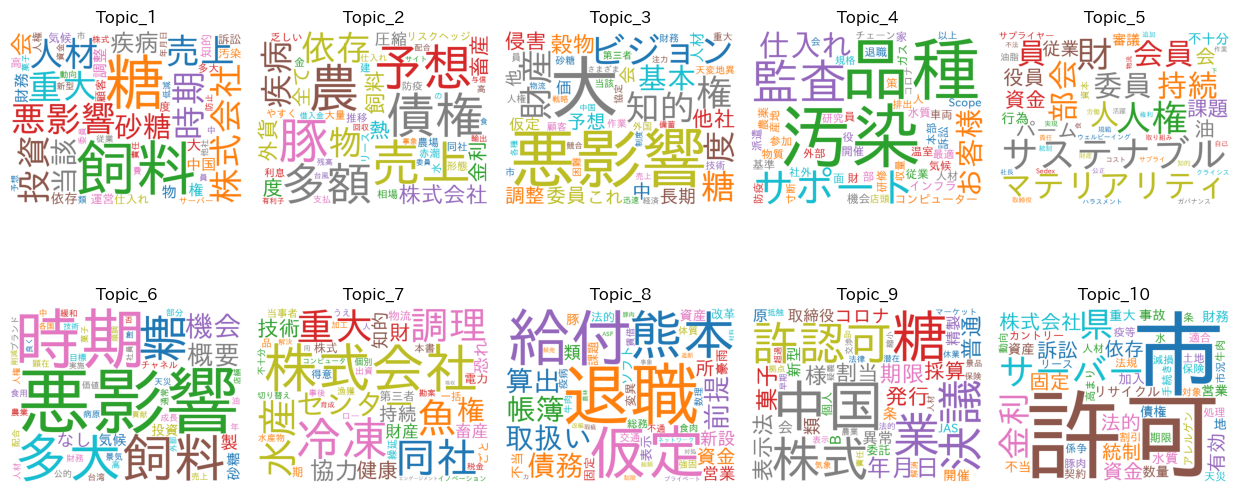

In [22]:
fig, ax = plt.subplots(2, 5, figsize=(12.5,6.5))
for itr_topic_num in range(NUM_TOPICS):
    row = itr_topic_num // 5
    col = itr_topic_num % 5
    wordcloud = wc.WordCloud(
        background_color="white",
        font_path=font_files[0],
        width=800,
        height=600,
        max_words=200,
        min_font_size=1,
        colormap='tab10',
    ).generate_from_frequencies(dict([(word,np.exp(score)-1) for word,score in lda.show_topic(itr_topic_num, topn=50)]))
    ax[row,col].imshow(wordcloud)
    ax[row,col].axis("off")
    ax[row,col].title.set_text("Topic_" + str(itr_topic_num+1))
fig.tight_layout()
plt.show()

## 4.2 事業の抽出

In [23]:
from edinet_xbrl_prep.text_prep import preproc_nlp

In [24]:
# 有価証券前段から事業の内容を取得し、前処理
business_desc_df = text_df.query("key == 'jpcrp_cor:DescriptionOfBusinessTextBlock'")
business_desc_df['text_processed'] = business_desc_df.data_str.apply(preproc_nlp,drop_htmp=True,drop_number=False,reduce_return=True)

In [25]:
# プロンプトの設定
example_text="""
##### 文章
3 【事業の内容】当社の主たる事業は物流業であります
その事業は貨物運送事業、倉庫事業、その他事業に区分されますが、それぞれの事業内容は次のとおりであります
イ 貨物運送事業貨物自動車運送事業法に基づく、一般貨物自動車運送事業の許可をうけて、愛知県、岐阜県、三重県、及び静岡県を営業区域とし、主に食料品、日用品雑貨等、消費関連貨物の輸送を行っております
また、貨物運送取扱事業法に基づく第一、第二種利用運送事業の許可もうけております
現在、愛知県下に8支店、三重県下に1支店の拠点を持ち、倉庫業とともに総合的な物流サービスの一環として効率的な輸送サービスの提供を行っております
ロ 倉庫事業倉庫業法に基づく倉庫業の許可をうけて、愛知県下に2か所の営業倉庫と6か所の物流センター、三重県下に1か所の物流センターを持ち、貨物運送事業との連携により集荷・保管・流通加工・配送・回収までの一貫した総合物流サービスに努めております
ハ その他事業道路運送車両法に基づく自動車分解整備事業の認証をうけて、愛知県下に1か所の整備工場民間車検工場指定を持ち、自動車の車検、定期点検、一般修理を行っておりますほか、付帯して損害保険代理店事業を営んでおります
また、三好支店において太陽光発電事業を行っております
 また、子会社大宝興業株式会社はビルの賃貸を主たる業務としております

##### 回答
```json
{"事業内容":"貨物運送事業","具体的な説明":"食料品、日用品雑貨等の消費関連貨物の輸送に加え、第一・第二種利用運送事業も実施。"}
{"事業内容":"倉庫事業","具体的な説明":"営業倉庫と物流センターの運営。集荷・保管・流通加工・配送・回収までの一貫したサービスを提供"}
{"事業内容":"自動車整備事業","具体的な説明":"車検、定期点検、一般修理"}
{"事業内容":"損害保険代理店事業","具体的な説明":"なし"}
{"事業内容":"太陽光発電事業","具体的な説明":"なし"}
{"事業内容":"不動産賃貸事業","具体的な説明":"なし"}
```
以上の指示に従って、提供された文章から、事業内容を抽出して整理してください。
"""

prompt_ext_business = Prompt(**{
    "instruction": """提供される文章はある会社の事業内容に関する文章の抜粋です。ここからわかる会社の主な事業内容を日本語で列挙してください。""",
    "example": example_text,
    "constraints_list": ["できるだけ文章中の記載をそのまま引用してください。","固有名詞は伏せてください。","具体的な説明がある場合は、それも記載してください。ない場合は「なし」としてください。"],
    "output_format": """#### 回答形式\n\nフォーマットは個別のjson形式で回答してください。\n\n{"事業内容":"(事業内容1)","具体的な説明":"(具体的な説明1)"}\n{"事業内容":"(事業内容2)","具体的な説明":"(具体的な説明2)"}""",
    })

sample_text="""3 【事業の内容】当社の主たる事業は物流業であります\nその事業は貨物運送事業、倉庫事業、その他事業に区分されますが、それぞれの事業内容は次のとおりであります\nイ 貨物運送事業貨物自動車運送事業法に基づく、一般貨物自動車運送事業の許可をうけて、愛知県、岐阜県、三重県、及び静岡県を営業区域とし、主に食料品、日用品雑貨等、消費関連貨物の輸送を行っております\nまた、貨物運送取扱事業法に基づく第一、第二種利用運送事業の許可もうけております\n現在、愛知県下に8支店、三重県下に1支店の拠点を持ち、倉庫業とともに総合的な物流サービスの一環として効率的な輸送サービスの提供を行っております\nロ 倉庫事業倉庫業法に基づく倉庫業の許可をうけて、愛知県下に2か所の営業倉庫と6か所の物流センター、三重県下に1か所の物流センターを持ち、貨物運送事業との連携により集荷・保管・流通加工・配送・回収までの一貫した総合物流サービスに努めております\nハ その他事業道路運送車両法に基づく自動車分解整備事業の認証をうけて、愛知県下に1か所の整備工場民間車検工場指定を持ち、自動車の車検、定期点検、一般修理を行っておりますほか、付帯して損害保険代理店事業を営んでおります\nまた、三好支店において太陽光発電事業を行っております\n また、子会社大宝興業株式会社はビルの賃貸を主たる業務としております"""

# 例を出力
prompt_ext_business.export_sample(sample_text)

NameError: name 'Prompt' is not defined

In [ ]:
your_api_key_groq: str = input("Please input your Groq API key: ")
GroqAPI_obj = GroqAPI(api_key=your_api_key_groq)

In [ ]:

def extract_business_description(sr:pd.Series)->list:
    sys_prompt,usr_prompt = prompt_ext_business.export(provided_text=sr.text_processed)
    response = GroqAPI_obj.request(sys_prompt=sys_prompt,usr_prompt=usr_prompt,model_name='llama-3.1-8b-instant')
    if not response.output_json_validation():
        sleep(1)
        response2 = GroqAPI_obj.request(sys_prompt=sys_prompt,usr_prompt=usr_prompt,model_name='llama-3.1-8b-instant')
        if not response2.output_json_validation():
            print("Error")
            return []
        else:
            response = response2
    output_json_list = response.extract_output_json()
    return output_json_list

# 120秒程度
business_desc_df['business_extracted'] = business_desc_df.apply(extract_business_description,axis=1)


In [ ]:
business_desc_df.head()[['docid','text_processed','business_extracted']]

,docid,text_processed,business_extracted
3,S100TMYO,\n3【事業の内容】\n 当グループ当社及び当社の関係会社は、当社亀田製菓株式会社、子会社1...,"[{'事業内容': '菓子の製造販売', '具体的な説明': 'なし'}, {'事業内容':..."
2,S100TNWB,\n3 【事業の内容】当社は、「安全と安心を優先に顧客に満足と感動を提供する\n」という経...,"[{'事業内容': '業務用冷凍食品の企画及び販売', '具体的な説明': 'エンドユーザー..."
3,S100TLP1,\n3 【事業の内容】当社の企業集団は、当社、子会社71社および関連会社18社で構成されて...,"[{'事業内容': '飲料および食品製造販売事業', '具体的な説明': '乳製品、清涼飲料..."
3,S100TN7J,\n3 【事業の内容】当社グループは、当社、連結子会社1社、持分法適用関連会社1社及びその...,"[{'事業内容': '精製糖の製造・販売', '具体的な説明': '原料糖は丸紅株式会社・丸..."
3,S100TO96,\n3【事業の内容】当社グループは持株会社制を導入しており、当社及び連結子会社11社、持分...,"[{'事業内容': 'ナチュラルミネラルウォーターの製造', '具体的な説明': '12l入..."


## 5. 財務数値の分析

### 5.1 在庫の分析

In [ ]:
# 設定
import matplotlib.pyplot as plt
import matplotlib_fontja
from matplotlib.cm import get_cmap
from sklearn.decomposition import PCA
from edinet_xbrl_prep.num_prep import preproc_num, fill_df

np.random.seed(seed=1)

In [ ]:
# BSの抽出
bs_df = fs_tbl_df_all.query("non_consolidated_flg==0 and current_flg==1 and role.str.contains('BalanceSheet')")

In [ ]:
# 在庫の抽出
inventory_df = bs_df.query("label_jp.str.contains('商品及び製品') or label_jp.str.contains('仕掛品') or label_jp.str.contains('原材料及び貯蔵品')")

In [ ]:
# 数値データの前処理
inventory_df = preproc_num(inventory_df) # テキストを数値に変換など
inventory_df_filled = fill_df(inventory_df) # 欠損値の補完
inventory_df_pivot = pd.crosstab(index=inventory_df_filled['docid'], columns=inventory_df_filled['label_jp'], values=inventory_df_filled['data'], aggfunc='sum',normalize='index')

AttributeError: 'DataFrame' object has no attribute 'precision'

In [ ]:
# 似ている企業が近くなるように並べ替え
def aitchison_scaling(x):
    """Aitchison距離計算用"""
    return np.log(x/np.exp(np.mean(np.log(x))))

def pca_sort(data:pd.DataFrame)->pd.DataFrame:
    """第一主成分でソート"""
    pca = PCA(n_components=1)

    data_scaled = data#.apply(aitchison_scaling, axis=1)
    data['pc1_scores'] = pca.fit_transform(data_scaled)

    sorted_df = data.sort_values('pc1_scores')
    sorted_df = sorted_df.drop('pc1_scores', axis=1)
    return sorted_df

reordered_inventory_df_pivot = pca_sort(inventory_df_pivot)


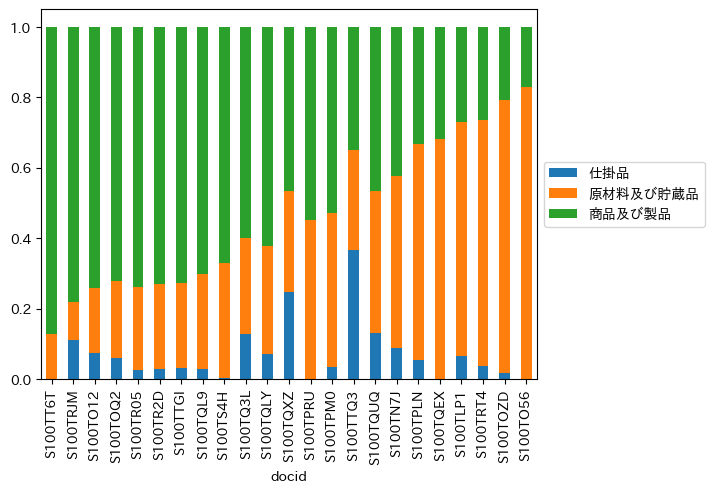

In [ ]:
# 積み上げ棒グラフの描画
reordered_inventory_df_pivot.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### 5.2 在庫の分析と事業

In [ ]:
# 4.2で取得した事業内容を結合
reordered_inventory_df_pivot2 = pd.merge(
    reordered_inventory_df_pivot,
    business_desc_df.set_index('docid')[['business_extracted']],
    left_index=True,
    right_index=True,
    how='left'
)

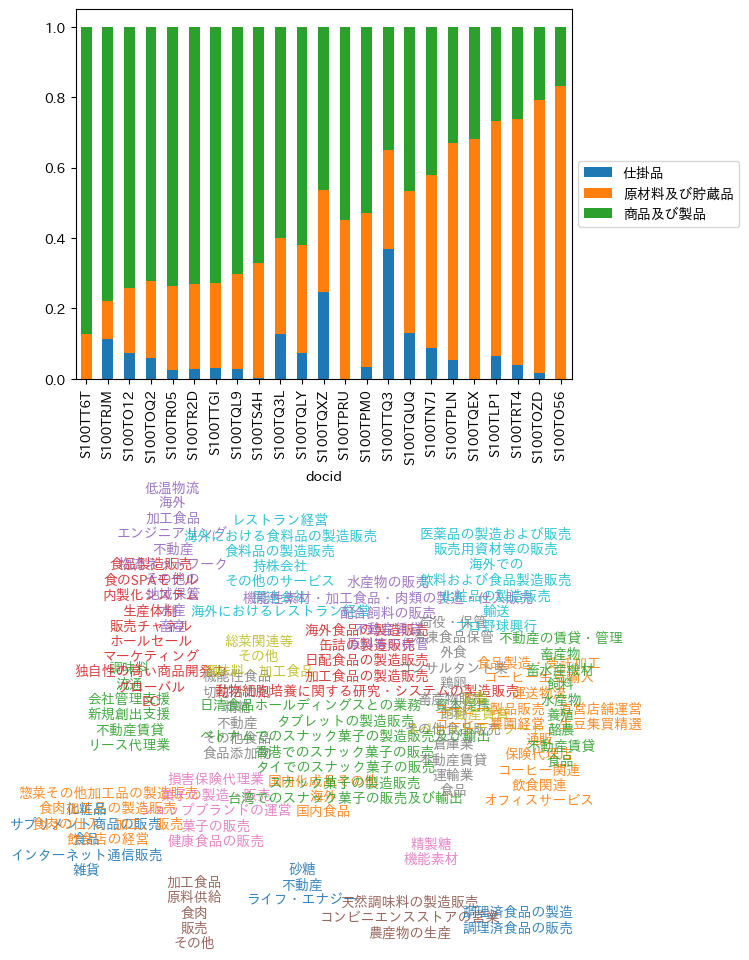

In [ ]:
# 事業内容と一緒に描画
cmap = get_cmap('tab10')

dic_box = {
    'facecolor' : 'lightblue',
    'edgecolor' : 'black',
    'boxstyle' : 'Round, pad=0.8',
    'linewidth' : 1
}
reordered_inventory_df_pivot2.plot(kind='bar', stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
for itr,index in enumerate(reordered_inventory_df_pivot2.index):
    text_list = reordered_inventory_df_pivot2.loc[index,'business_extracted']
    if text_list is not np.nan:
        text = "\n".join(list(set([text['事業内容'] for text in text_list]))).replace('事業','')
        plt.text(x=itr, y=-1.7 + 0.2*(itr % 5) + 0.3*np.random.rand(), s=text, 
            color=cmap(itr % 10),
            ha='center', fontsize='10', alpha=0.9,
            #bbox=dic_box
            )

### 5.3 営業利益率の分析

In [ ]:
# PLの取得
pl_df=fs_tbl_df_all.query("non_consolidated_flg==0 and current_flg==1 and role.str.contains('StatementOfIncome')")

In [ ]:
# PLから営業利益の取得
profit_df = pl_df.query("label_jp.str.contains('営業利益又は営業損失（△）')")
profit_df = preproc(profit_df)
profit_df = profit_df.sort_values('context_ref_len',ascending=True).drop_duplicates(keep='first',subset=['docid','key'])
len(profit_df)

24

In [ ]:
# PLから売上の取得
sales_df = pl_df.query("label_jp.str.contains('売上高')")
sales_df = preproc(sales_df)
sales_df = sales_df.sort_values('context_ref_len',ascending=True).drop_duplicates(keep='first',subset=['docid','key'])
len(sales_df)

24

In [ ]:
# PLから総資産の取得
scaler_df = bs_df.query("key == 'jppfs_cor:Assets'")
scaler_df = preproc(scaler_df)
scaler_df = scaler_df.sort_values('context_ref_len',ascending=True).drop_duplicates(keep='first',subset=['docid','key'])
len(scaler_df)

24

Text(0, 0.5, 'Profit rate (million yen)')

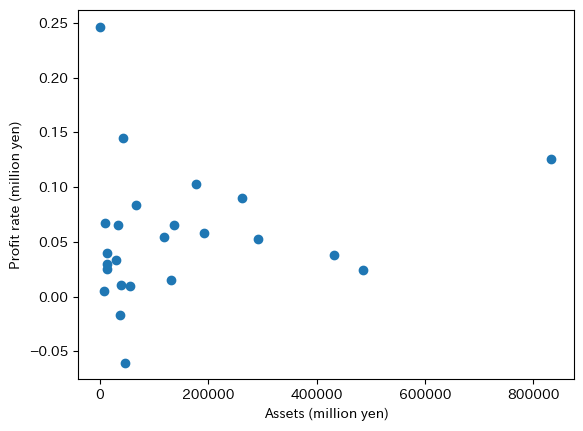

In [ ]:
# 散布図の描画
plt.scatter(scaler_df.set_index('docid').data/1000000, profit_df.set_index('docid').data/sales_df.set_index('docid').data)
plt.xlabel('Assets (million yen)')
plt.ylabel('Profit rate (million yen)')

## 6. SQLITE3への出力

In [ ]:
fs_tbl_df_all.rename(columns={'key':'account_code','label_jp':'account_name','docid':'document_code'},inplace=True)

,key,data_str,decimals,precision,context_ref,element_name,unit,period_type,isTextBlock_flg,abstract_flg,period_start,period_end,instant_date,role,label_jp,order,docid,non_consolidated_flg,current_flg,prior_flg
0,jppfs_cor:CashAndDeposits,2657108000,-3,None,Prior1YearInstant_NonConsolidatedMember,CashAndDeposits,JPY,instant,0,0,None,2023-04-01,2023-04-01,rol_BalanceSheet,現金及び預金,1.020101,S100TNWB,1,0,1
1,jppfs_cor:CashAndDeposits,3873928000,-3,None,CurrentYearInstant_NonConsolidatedMember,CashAndDeposits,JPY,instant,0,0,None,2024-04-01,2024-04-01,rol_BalanceSheet,現金及び預金,1.020101,S100TNWB,1,1,0
2,jppfs_cor:NotesReceivableTrade,31632000,-3,None,Prior1YearInstant_NonConsolidatedMember,NotesReceivableTrade,JPY,instant,0,0,None,2023-04-01,2023-04-01,rol_BalanceSheet,受取手形,1.020101,S100TNWB,1,0,1
3,jppfs_cor:NotesReceivableTrade,46153000,-3,None,CurrentYearInstant_NonConsolidatedMember,NotesReceivableTrade,JPY,instant,0,0,None,2024-04-01,2024-04-01,rol_BalanceSheet,受取手形,1.020101,S100TNWB,1,1,0
4,jppfs_cor:AccountsReceivableTrade,4658698000,-3,None,Prior1YearInstant_NonConsolidatedMember,AccountsReceivableTrade,JPY,instant,0,0,None,2023-04-01,2023-04-01,rol_BalanceSheet,売掛金,1.020101,S100TNWB,1,0,1


In [240]:
import	sqlite3

file_sqlite3 = DATA_PATH / "xbrl_parsed.db"
conn = sqlite3.connect(str(file_sqlite3))
fs_tbl_df_all.to_sql('xbrl_parsed',conn,index=None,if_exists='replace')
conn.close()
